In [1]:
import xarray as xr
import hvplot.xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import datetime as dt
import tqdm
from climtas.nci import GadiClient
import glob
import metpy
from working.sea_breeze.load_barra import load_barra_wind_data, load_barra_variable, load_barra_static,get_intake_cat
from working.sea_breeze.coastline_funcs import get_coastline, get_coastline_angle, latlon_dist


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
client = GadiClient()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37289,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:42889,Total threads: 1
Dashboard: /proxy/43099/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:38675,


In [3]:


# t1 = "2024-01-24 00:00"
# t2 = "2024-02-02 01:00"
# wind_ds = load_barra_wind_data(
#     ["uas"],
#     ["vas"],
#     ["ws_sfc"],
#     t1,
#     t2,
#     "AUS-11",
#     "1hr",
#     lat_slice,
#     lon_slice)


# huss = load_barra_variable("huss",t1,t2,"AUS-11","1hr",lat_slice,lon_slice)
# ts = load_barra_variable("ts",t1,t2,"AUS-11","1hr",lat_slice,lon_slice)
# ps = load_barra_variable("ps",t1,t2,"AUS-11","1hr",lat_slice,lon_slice)

In [4]:
lat_slice = slice(-45,-20)
lon_slice = slice(140,156)
orog, lsm = load_barra_static("AUS-11",lon_slice,lat_slice)
lsm_ds = get_coastline(lsm)
lsm_ds = get_coastline_angle(lsm_ds, R=300, N=10)

Defining coastline angles...


100%|██████████| 145/145 [00:02<00:00, 66.86it/s]


Expanding angles to average of closest 10 points within 300 kms...


100%|██████████| 228/228 [02:03<00:00,  1.85it/s]


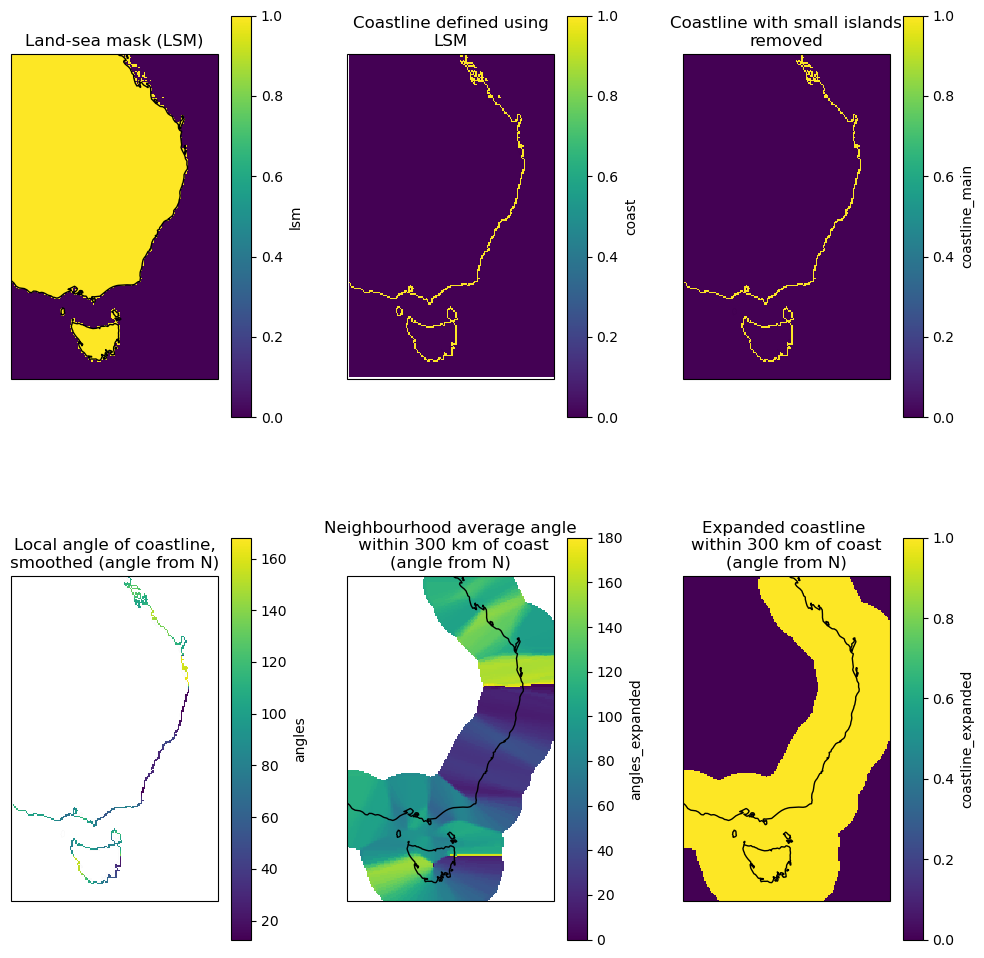

In [8]:
plt.figure(figsize=[12,12])
ax=plt.subplot(2,3,1,projection=ccrs.PlateCarree())
lsm_ds.lsm.plot()
plt.title("Land-sea mask (LSM)")
ax.coastlines()

ax=plt.subplot(2,3,2,projection=ccrs.PlateCarree())
lsm_ds.coast.plot()
plt.title("Coastline defined using\nLSM")
ax.coastlines(lw=0.01)

ax=plt.subplot(2,3,3,projection=ccrs.PlateCarree())
lsm_ds.coastline_main.plot()
plt.title("Coastline with small islands\nremoved")
ax.coastlines(lw=0.01)

ax=plt.subplot(2,3,4,projection=ccrs.PlateCarree())
lsm_ds.angles.plot()
plt.title("Local angle of coastline,\nsmoothed (angle from N)")
ax.coastlines(lw=0.01)

ax=plt.subplot(2,3,5,projection=ccrs.PlateCarree())
lsm_ds.angles_expanded.plot(vmin=0,vmax=180)
plt.title("Neighbourhood average angle\n within 300 km of coast\n(angle from N)")
ax.coastlines()

ax=plt.subplot(2,3,6,projection=ccrs.PlateCarree())
lsm_ds.coastline_expanded.plot()
plt.title("Expanded coastline \nwithin 300 km of coast\n(angle from N)")
ax.coastlines()

plt.subplots_adjust(hspace=0.3,wspace=0.3)

In [10]:
lat_slice = slice(-45,-39)
lon_slice = slice(143,150)
orog, lsm = load_barra_static("AUS-11",lon_slice,lat_slice)
lsm_ds = get_coastline(lsm)
lsm_ds = get_coastline_angle(lsm_ds, R=300, N=10)

Defining coastline angles...


100%|██████████| 64/64 [00:00<00:00, 342.11it/s]


Expanding angles to closest 10 points...


100%|██████████| 55/55 [00:03<00:00, 14.34it/s]


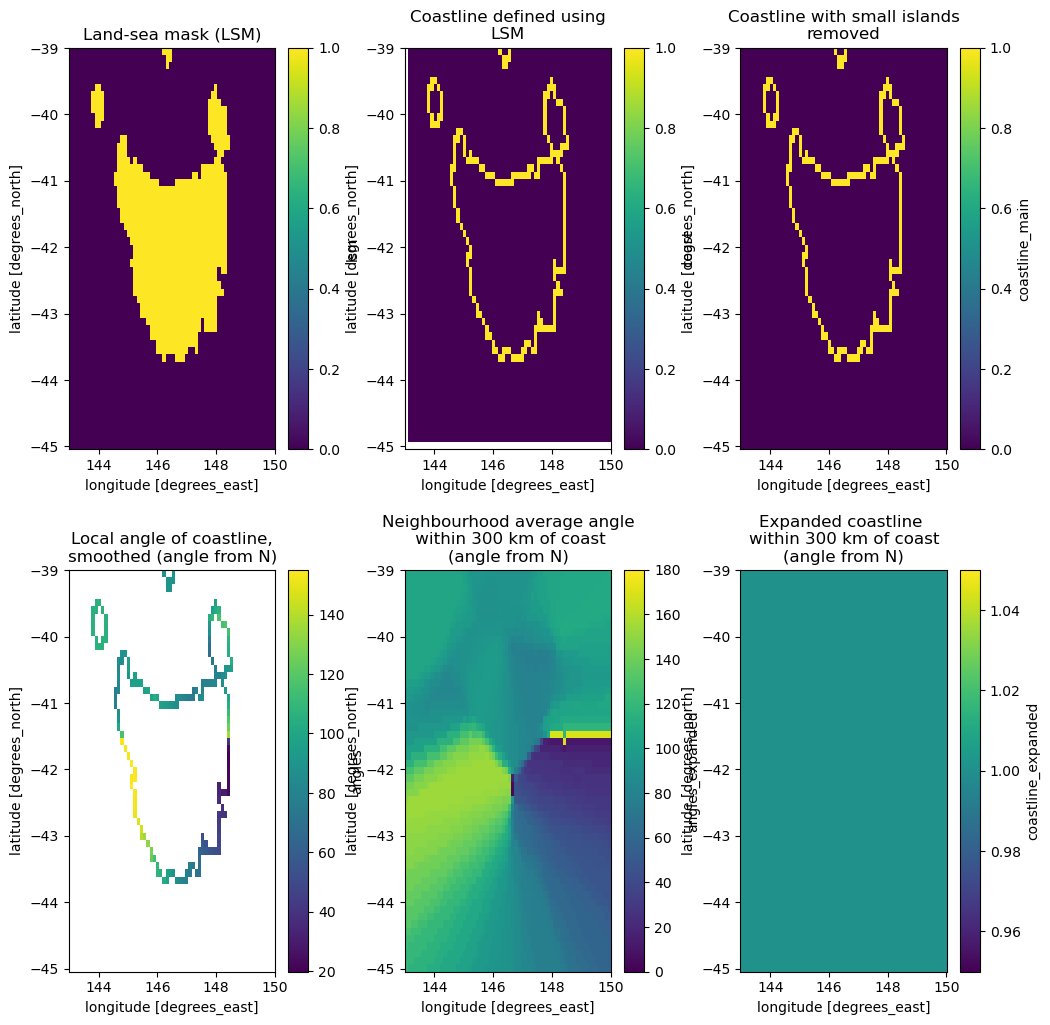

In [11]:
plt.figure(figsize=[12,12])
plt.subplot(2,3,1)
lsm_ds.lsm.plot()
plt.title("Land-sea mask (LSM)")

plt.subplot(2,3,2)
lsm_ds.coast.plot()
plt.title("Coastline defined using\nLSM")

plt.subplot(2,3,3)
lsm_ds.coastline_main.plot()
plt.title("Coastline with small islands\nremoved")

plt.subplot(2,3,4)
lsm_ds.angles.plot()
plt.title("Local angle of coastline,\nsmoothed (angle from N)")

plt.subplot(2,3,5)
lsm_ds.angles_expanded.plot(vmin=0,vmax=180)
plt.title("Neighbourhood average angle\n within 300 km of coast\n(angle from N)")

plt.subplot(2,3,6)
lsm_ds.coastline_expanded.plot()
plt.title("Expanded coastline \nwithin 300 km of coast\n(angle from N)")

plt.subplots_adjust(hspace=0.3,wspace=0.3)

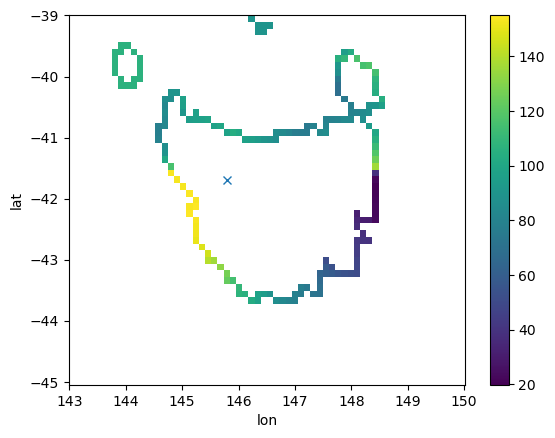

In [8]:
import scipy
xi=30
yi=25
x = lsm_ds.lon.values
y = lsm_ds.lat.values
xx,yy = np.meshgrid(x,y)
R=300

dist = latlon_dist(yy[xi,yi], xx[xi,yi], yy, xx)
# np.rad2deg(
#     scipy.stats.circmean(
#     np.deg2rad(xr.where((lsm_ds.coastline_main) & (dist<=R),lsm_ds.angles,np.nan)), 
#     high=np.pi, low=0, nan_policy="omit"))

(xr.where((lsm_ds.coastline_main) & (dist<=R),lsm_ds.angles,np.nan)).plot()
plt.plot(xx[xi,yi], yy[xi,yi],marker="x")

array([153.96868783, 154.14717804, 153.28816972, 154.68659024,
       152.98923393, 153.92256071,  96.99892772, 155.05898396,
        95.87621914, 153.82202815])

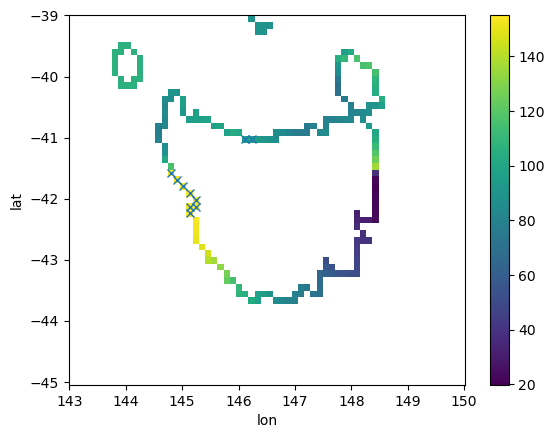

In [30]:
N=10
R=300
flattened_xx = xx.flatten()
flattened_yy = yy.flatten()
flattened_angles = lsm_ds.angles.values.flatten()
closest_n_xx = flattened_xx[np.argsort(xr.where((lsm_ds.coastline_main),dist,np.nan).values,axis=None)[0:N]]
closest_n_yy = flattened_yy[np.argsort(xr.where((lsm_ds.coastline_main),dist,np.nan).values,axis=None)[0:N]]

(xr.where((lsm_ds.coastline_main) & (dist<=R),lsm_ds.angles,np.nan)).plot()
plt.plot(closest_n_xx, closest_n_yy, marker="x", ls="none")

flattened_angles[np.argsort(xr.where((lsm_ds.coastline_main),dist,np.nan).values,axis=None)[0:N]]

In [26]:
R=None
N=None

assert (R is not None) | (N is not None), "R or N must be an integer"

AssertionError: R or N must be an integer

In [16]:
# def plot_sfc_wind(sfc_wind,ax,vmax=None,vmin=None,cmap=None,ws=True):
#     if ws:
#         sfc_wind.ws_sfc.plot(vmax=vmax,vmin=vmin,cmap=cmap)
#     sfc_wind[["uas","vas"]].coarsen({"lon":2,"lat":2},boundary="pad").mean().plot.quiver(x="lon",y="lat",u="uas",v="vas")
#     ax.coastlines()
#     ax.gridlines(draw_labels=True)

# def plot_ds(ds,var_name,ax,vmin=None,vmax=None,cmap=None):
#     ds[var_name].plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap)

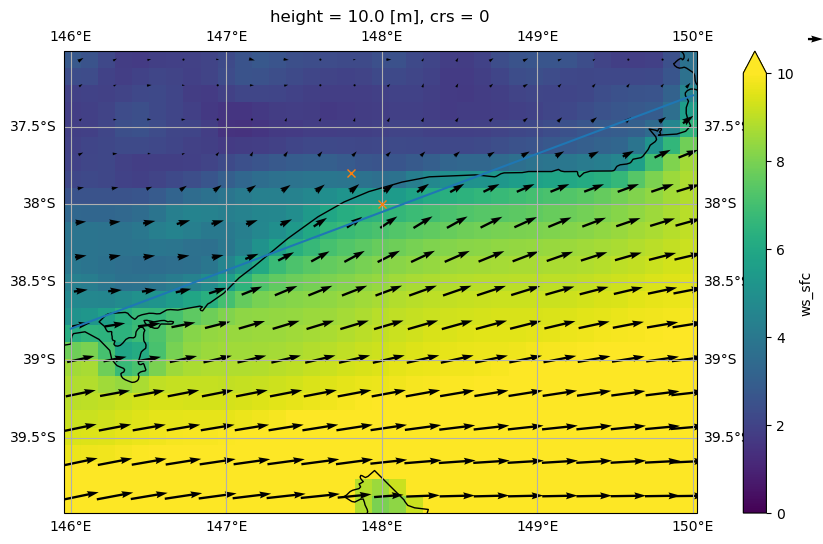

In [17]:
# lat_slice_gipps = slice(-40,-37)
# lon_slice_gipps = slice(146,150)

# plt.figure(figsize=[12,6])
# ax=plt.axes(projection=ccrs.PlateCarree())
# plot_sfc_wind(wind_ds.mean("time").sel(lat=lat_slice_gipps,lon=lon_slice_gipps), ax, vmin=0, vmax=10)
# plt.gca().plot(148,-38,marker="x",color="tab:orange")
# plt.gca().plot(147.8,-37.8,marker="x",color="tab:orange")
# plt.plot([146,150],[-38.8,-37.3])